In [2]:
# Cell 1 – libraries
import numpy as np
from numpy import exp, log, sqrt
from scipy.stats import norm, qmc
from tqdm.auto import trange
import matplotlib.pyplot as plt


---
# Underlying Simulation from "Modelling spikes and pricing swing options in electricity markets" Hambly et al. (2009)

Simulated 16384 paths; mean S(T) = 179.54


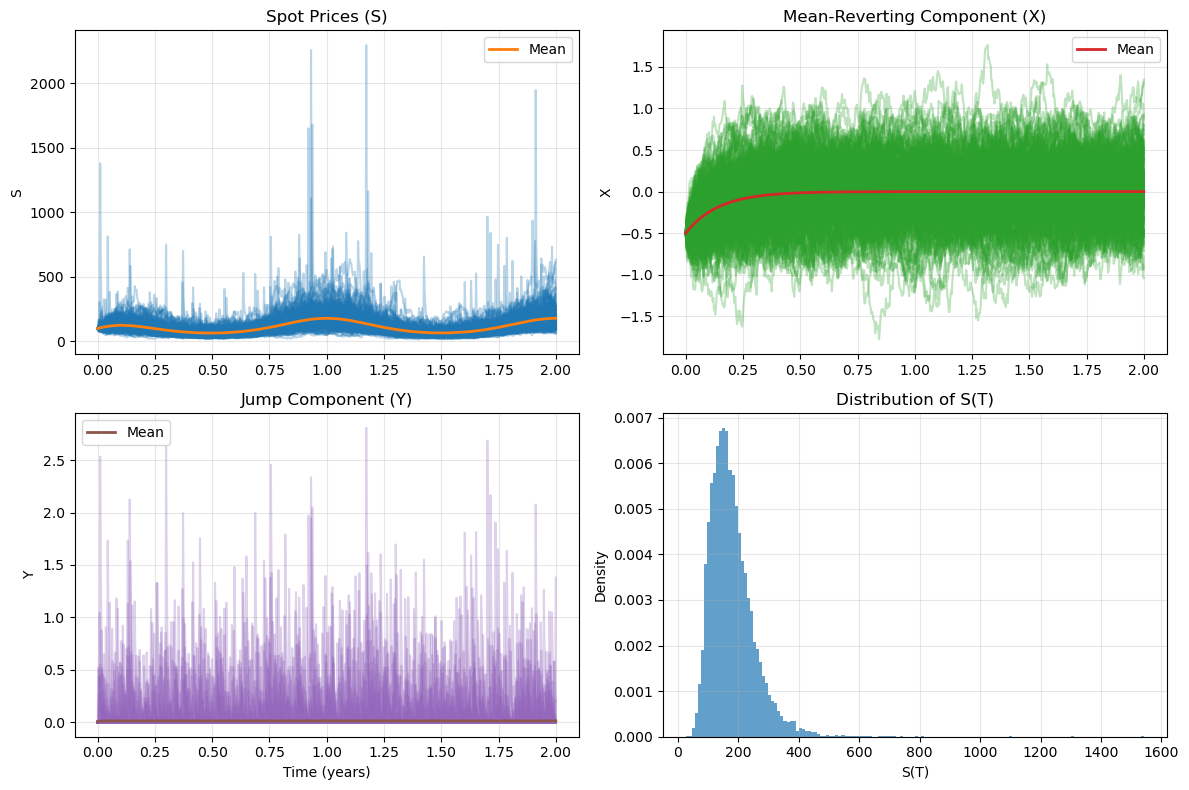


Final spot price statistics:
Mean: 179.54
Std : 74.38
Min : 25.77
Max : 1541.82


In [3]:
import numpy as np
from scipy.stats import qmc, norm, poisson, gamma
import matplotlib.pyplot as plt

def simulate_hhk_spot(
    S0: float,
    T: float,
    n_steps: int,
    n_paths: int,
    alpha: float,
    sigma: float,
    beta: float,
    lam: float,
    mu_J: float,
    f: callable,
    seed: int | None = None,
):
    """
    Hambly–Howison–Kluge spot model with exponential jump sizes.
    Returns time grid t, spot paths S, X-state, Y-state.
    """
    dt   = T / n_steps
    t    = np.linspace(0.0, T, n_steps + 1)

    # Exact OU step statistics
    e_m  = np.exp(-alpha * dt)
    var_m = sigma**2 * (1.0 - e_m**2) / (2.0 * alpha)
    e_y  = np.exp(-beta * dt)

    # Sobol backbone: Z_X, U_Poi, U_Gamma
    dim_per_step = 3
    sampler = qmc.Sobol(d=dim_per_step * n_steps, scramble=True, seed=seed)
    u = sampler.random(n_paths).reshape(n_paths, n_steps, dim_per_step).transpose(1, 0, 2)

    eps = 1e-12
    u = np.clip(u, eps, 1.0 - eps)

    z_x   = norm.ppf(u[:, :, 0])
    n_jmp = poisson.ppf(u[:, :, 1], lam*dt).astype(int)
    u_gam = u[:, :, 2]

    # State arrays
    X = np.empty((n_paths, n_steps + 1))
    Y = np.empty((n_paths, n_steps + 1))
    S = np.empty((n_paths, n_steps + 1))
    X[:, 0] = np.log(S0) - f(0.0)
    Y[:, 0] = 0.0
    S[:, 0] = S0

    for k in range(1, n_steps + 1):
        # OU X
        X[:, k] = e_m * X[:, k-1] + np.sqrt(var_m) * z_x[k-1]

        # Y mean-reverting jumps
        n_k = n_jmp[k-1]
        jump_sum = np.where(
            n_k > 0,
            gamma.ppf(u_gam[k-1], a=n_k, scale=mu_J),
            0.0
        )
        Y[:, k] = e_y * Y[:, k-1] + jump_sum

        # spot
        S[:, k] = np.exp(f(t[k]) + X[:, k] + Y[:, k])

    return t, S, X, Y

# --- Parameters matching HHK paper ---
params = dict(
    S0      = 100.0,
    T       = 2.0,          # 2 years
    n_steps = 730,          # daily
    n_paths = 16_384,
    alpha   = 7.0,
    sigma   = 1.4,
    beta    = 200.0,
    lam     = 4.0,
    mu_J    = 0.4,          # use 0.8 for “big-jump”
    f       = lambda t: np.log(100.0) + 0.5 * np.cos(2 * np.pi * t),
    seed    = 42,
)

# === Simulate ===
t, S, X, Y = simulate_hhk_spot(**params)
print(f"Simulated {S.shape[0]} paths; mean S(T) = {S[:, -1].mean():.2f}")

# === Diagnostic 2×2 plot and summary stats ===
n_paths_to_plot = 200
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Top-left: spot paths
axes[0, 0].plot(t, S[:n_paths_to_plot].T, color="tab:blue", alpha=0.3)
axes[0, 0].plot(t, S.mean(axis=0), color="tab:orange", lw=2, label="Mean")
axes[0, 0].set_title("Spot Prices (S)")
axes[0, 0].set_ylabel("S")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# Top-right: X factor
axes[0, 1].plot(t, X[:n_paths_to_plot].T, color="tab:green", alpha=0.3)
axes[0, 1].plot(t, X.mean(axis=0), color="tab:red", lw=2, label="Mean")
axes[0, 1].set_title("Mean-Reverting Component (X)")
axes[0, 1].set_ylabel("X")
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# Bottom-left: Y factor
axes[1, 0].plot(t, Y[:n_paths_to_plot].T, color="tab:purple", alpha=0.3)
axes[1, 0].plot(t, Y.mean(axis=0), color="tab:brown", lw=2, label="Mean")
axes[1, 0].set_title("Jump Component (Y)")
axes[1, 0].set_xlabel("Time (years)")
axes[1, 0].set_ylabel("Y")
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# Bottom-right: histogram of terminal prices
axes[1, 1].hist(S[:, -1], bins=150, density=True, alpha=0.7, color="tab:blue")
axes[1, 1].set_title("Distribution of S(T)")
axes[1, 1].set_xlabel("S(T)")
axes[1, 1].set_ylabel("Density")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# === Final spot price statistics ===
print("\nFinal spot price statistics:")
print(f"Mean: {S[:, -1].mean():.2f}")
print(f"Std : {S[:, -1].std():.2f}")
print(f"Min : {S[:, -1].min():.2f}")
print(f"Max : {S[:, -1].max():.2f}")